# Información General:
- Autor: Javier Meitín Moreno
- ID: JDLA10
- Título: Reconocimiento de emociones a partir de voz (Shallow ANN)
- Director(es): Javier De Lope Asiaín
- **Versión Auxiliar: Este documento ha sido empleado de forma auxiliar para realizar las múltiples pruebas de optimización de hiperparámetros. Por favor, consulte el documento <<TFM - Modelo Shallow ANN Final.ipynb>> para ver la propuesta final del modelo.**


# 1. Installs

In [ ]:
!pip install tensorflow
#IMAGEN
!pip install librosa numpy matplotlib scikit-image
#IMPORTANCIA CARACTERISTICAS
!pip install shap
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=a0edba31a1d17234251fd37171dbd227a5c9d7173f21f5e4e8f2f37c819dade1
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


#2. Imports

In [ ]:
import random
import os # Cargar archivos wav e iterar sobre ellos
import librosa # Convertir .WAV a IMG
import librosa.display # Convertir .WAV a IMG
import matplotlib.pyplot as plt
import numpy as np
import cv2 # interpolacion para alargar la imagen
import seaborn as sns # confusion matrix

from scipy.ndimage import zoom # Reducir la dimensionalidad de las imágenes
from skimage import io, color, exposure, transform #Cargar png
#Red Neuronal:
import pickle #guardar/cargar history de un archivo
import tensorflow as tf
from tensorflow.keras.models import load_model #Guardar/cargar model de un archivo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report #confusion matrix
#IMPORTANCIA Gradient Boosting
import xgboost as xgb

#3. Montar Google Drive

In [ ]:
# Google file system
from google.colab import drive
drive.mount('/GoogleDrive', force_remount=True)

RUTA = "/GoogleDrive/My Drive/Colab Notebooks/datasets/"
RUTA_WAV = RUTA + "RAVDESS_Audio_Speech/"
RUTA_IMG = RUTA + "RAVDESS_Audio_Speech_Img/"

Mounted at /GoogleDrive


#4. Preparar y procesar los datos
No todos los audios miden lo mismo. No solo varía la longitud de la frase, si no el silencio antes y después de la oración. Por estos motivos, hay que transformar los datos.

## 4.1. Método auxiliar para que eliminar los silencios:
- Necesitamos quitar el silencio al principio y al final del audio.
- El silencio se refleja con el pixel a negro (-80)

In [ ]:
UMBRAL_SILENCIO = -80  # Umbral para considerar una columna como silencio

def delete_silence(img):
  # Encuentra los índices del primer y último tiempo donde no hay silencio
  inicio_voz = np.argmax(np.any(img > UMBRAL_SILENCIO, axis=0))
  fin_voz = len(img[0]) - np.argmax(np.any(img[:, ::-1] > UMBRAL_SILENCIO, axis=0)[::-1])

  # Recorta el espectrograma para eliminar el silencio al principio y al final
  new_img = img[:, inicio_voz:fin_voz]

  return new_img

## 4.2. Método auxiliar para redimensionar una imagen:
- Todos los espectogramas tienen 1025 pixels de alto, pero el ancho oscila (143, 135, 167, etc).
- Esto es debido a que no todos los audios duran lo mismo.
- Para la RN, necesitamos que todas las imágenes sean iguales.
- Además, también es útil hacer las imágenes más pequeñas con el fin de que haya menos características durante el entrenamiento.


In [ ]:
def resize_img(img, new_width = 66, new_height = 150):
    new_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

    return new_img

##4.3. Método auxiliar para pintar un espectograma:

In [ ]:
def plt_espectograma(img, sr):
  # Visualizar el espectrograma
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(img, sr=sr, x_axis='time', y_axis='log')
  plt.axis('on')
  plt.colorbar(format='%+2.0f dB')
  plt.tight_layout()

  print("Dimensiones: ", img.shape)
  plt.show()

  plt.close() # Importante para que sea más eficiente al ejecutar en bucle.

## 4.4. Convertir un archivo WAV a Espectograma
Para facilitar que la red neuronal aprenda los archivos de audio, los transformamos previamente a espectogramas. Así solo tenemos que gestionar imágenes.

**1) Calcular el espectograma: Anwer SLIMI (2021) usan los mismos parametros que Promod Yenigalla (2018)!!!**

- **"Although the resolution of frequencies is related to both the
window size and the sampling rate of the audio signal, J. Zhao et
al [13] and P. Yenigalla et al [14] used both the log Mel
spectrogram with the same parameters window size= 2048 and
overlap= 512 on different sampling rates. Anyhow, in our work,
we resampled all the data to 22050 Hz then we used the same
parameters in [13][14] to generate our spectrograms:"*
- n_fft=2048: Define la longitud de la ventana de la transformada de Fourier de tiempo corto (STFT) en 2048.
- hop_length=512: Define el tamaño del salto entre ventanas sucesivas de la STFT en 512.
- n_mels=128/HEIGHT: Especifica el número de filtros mel para calcular el espectrograma mel.
- fmax=8000: Fija la frecuencia máxima en 8000 Hz para limitar el rango de frecuencia.

**2) Transformar las imagenes:**
- **"The generated spectrograms for our SER system are represented
in RGBa color model where their length equals to 3600 pixels and
their width equals to 2400 pixel."*
- Tras eliminar los silencios, necesitamos redimensionar las imagenes para que sean iguales.
- Realizando un estuvio previo, determinamos que el WIDTH medio de las imagenes es 140. Por este motivo, alargaremos/estrecharemos las imagenes mediante INTERPOLACION LINEAL para que sean todas de 140.
- REDUCCION DE CARACTERÍSTICAS: Una vez todas las imagenes son iguales, las hacemos más pequeñas para facilitar el aprendizaje.

In [ ]:
NEW_WIDTH = 2400
NEW_HEIGHT = 3600

def convert_wav_to_img(file_name, show_img = False):
  audio_file_path = RUTA_WAV + file_name + ".wav"#"03-01-01-01-01-01-01.wav"

  # Genererar el espectrograma ==> Promod Yenigalla (2018)
  y, sr = librosa.load(audio_file_path, sr=22050) # Resampleo a 22050 Hz
  espectrograma = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128, fmax=8000)
  espectrograma_db = librosa.power_to_db(espectrograma, ref=np.max)

  # Si no nos limitamos al oido humano
  #y, sr = librosa.load(audio_file_path, sr=22050)
  #espectrograma_db = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

  # ELIMINAR SILENCIO
  espectograma_sin_ruido = delete_silence(espectrograma_db)

  # REDIMENSIONAR LA IMAGEN 128x??? ==> 128x140
  espectrograma_ajustado = resize_img(espectograma_sin_ruido, 140, 128)

  #Comprobar que la imagen resultante mide 150x66:
  # if espectrograma_ajustado.shape[0] != 150 or espectrograma_ajustado.shape[1] != 66:
  #   print("Archivo problemático: ", file_name)
  #   print("El tamaño original del espectograma es: ", espectograma_sin_ruido.shape)
  #   print("El nuevo tamaño del espectograma es: ", espectrograma_ajustado.shape)

  # Reducción de dimensionalidad de la imagen ==> 150 x 66
  #espectrograma_reducido = resize_img(espectrograma_ajustado) # por defecto lo pone a 150 x 66 si no especificas.
  #espectrograma_reducido = zoom(espectrograma_ajustado, 0.2) #Reducir dimensionalidad manteniendo el aspect ratio
  espectrograma_reducido = zoom(espectrograma_ajustado, 0.7) # 128x140 ==> 90x98 = 8820 pixels
  #espectrograma_reducido = resize_img(espectrograma_ajustado) # Por defecto lo pone a 150x66

  # if espectrograma_reducido.shape[0] != 150 or espectrograma_reducido.shape[1] != 66:
  #   print("Archivo problemático: ", file_name)
  #   print("El tamaño reducido del espectograma es: ", espectrograma_reducido.shape)

  # Visualizar el espectrograma
  if show_img == True:
    print("=== Imagen Original ===")
    plt_espectograma(espectrograma_db, sr)
    print("=== Imagen sin silencio ===")
    plt_espectograma(espectograma_sin_ruido, sr)
    print("=== Imagen Alargada ===")
    plt_espectograma(espectrograma_ajustado, sr)
    print("=== Imagen Reducida ===")
    plt_espectograma(espectrograma_reducido, sr)

  # GUARDAR IMAGEN
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(espectrograma_reducido, sr=sr, x_axis='time', y_axis='log')

  plt.axis('off') # Quitar bordes blancos/unidades de medida
  plt.savefig(RUTA_IMG + file_name + ".png", bbox_inches='tight', pad_inches=0)

  plt.close() # Importante para que sea más eficiente al ejecutar en bucle.

  return espectrograma_reducido, espectograma_sin_ruido.shape[1]

Ejemplo para comprobar como funciona:

=== Imagen Original ===
Dimensiones:  (128, 143)


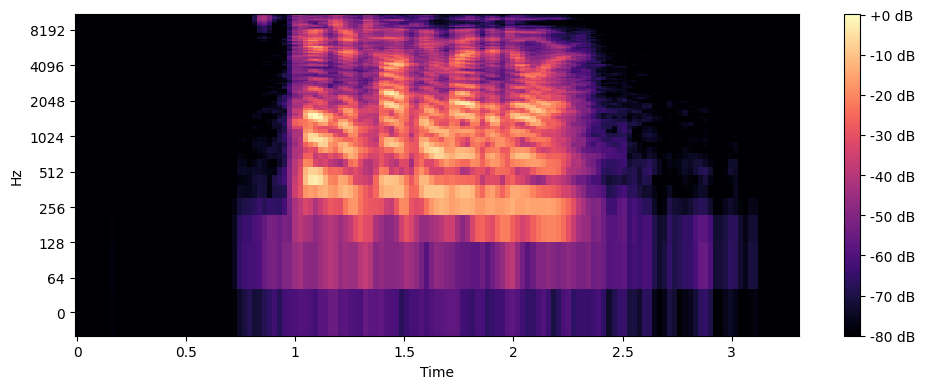

=== Imagen sin silencio ===
Dimensiones:  (128, 129)


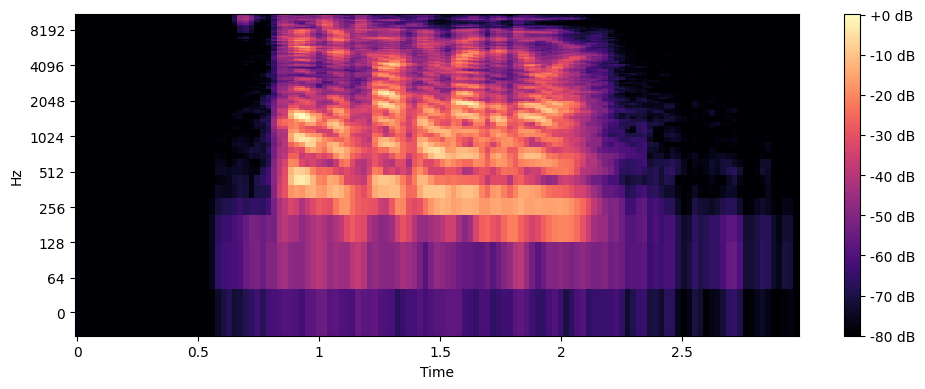

=== Imagen Alargada ===
Dimensiones:  (128, 140)


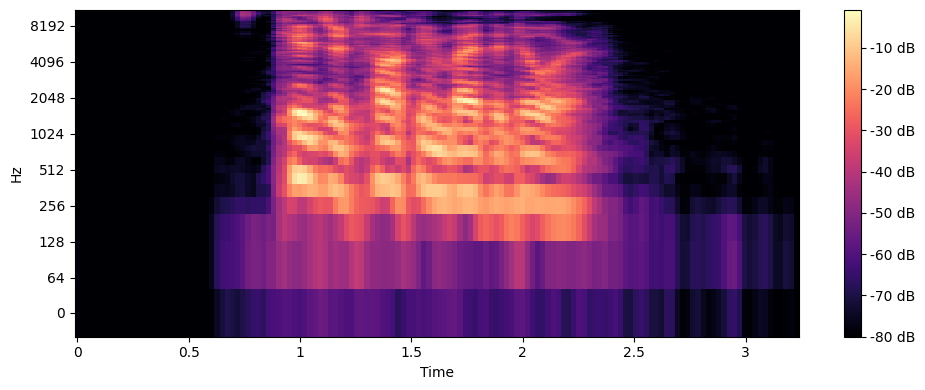

=== Imagen Reducida ===
Dimensiones:  (90, 98)


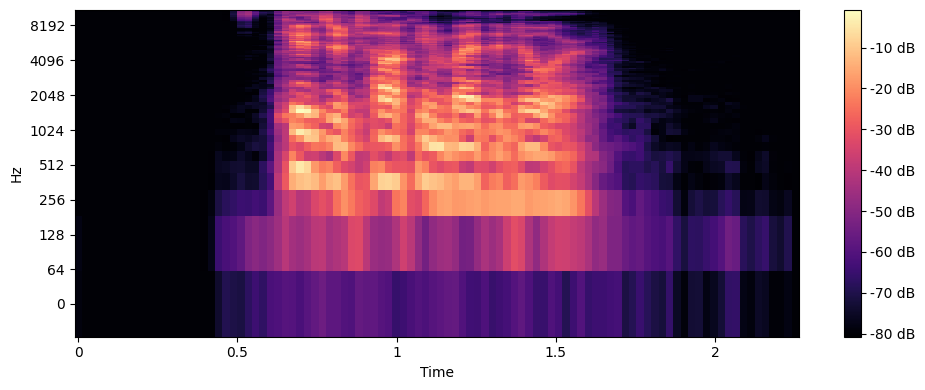

Emotion:  1


In [ ]:
file_name = "03-01-01-01-01-01-01"
convert_wav_to_img(file_name, show_img = True)
print("Emotion: ", file_name[7])

##4.6. Cargar los archivos y transormarlos a imágenes
**Filename identifiers:**
- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = - fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [ ]:
# Listar archivos en la carpeta
archivos_de_audio = [archivo for archivo in os.listdir(RUTA_WAV) if archivo.endswith(".wav")]

espectrogramas_lista = []
emociones_lista = []
widths_sin_ruido = []

# Procesar cada archivo de audio en un bucle
for archivo in archivos_de_audio:
  # Cargar el archivo de audio
  file_name = os.path.splitext(archivo)[0] # le quito el ".wav" al archivo.
  espectrograma, width_sin_ruido = convert_wav_to_img(file_name)
  emocion = file_name[7]

  espectrogramas_lista.append(espectrograma)
  emociones_lista.append(emocion)
  widths_sin_ruido.append(width_sin_ruido)

  if emocion == '1' and random.random() <= 0.98:
    espectrogramas_lista.append(espectrograma)
    emociones_lista.append(emocion)
    widths_sin_ruido.append(width_sin_ruido)

X = np.array(espectrogramas_lista)
y = np.array(emociones_lista)

# ES NECESARIO APLANAR LAS IMAGENES EN 1D? X_aplanado = X.reshape(X.shape[0], -1)
print(X.shape)
X = X.reshape(X.shape[0], -1)
print(X.shape)
print(y.shape)

(1541, 90, 98)
(1541, 8820)
(1541,)


Codigo auxiliar para estudiar la longitud de los audios.

In [ ]:
widths_sin_ruido_np = np.array(widths_sin_ruido)
widths_sin_ruido_np.sort()
print("Mediana: ", np.median(widths_sin_ruido_np))
print("Media: ", np.mean(widths_sin_ruido_np))

print (np.count_nonzero(y =='1'))
print (np.count_nonzero(y =='2'))
print (np.count_nonzero(y =='3'))
print (np.count_nonzero(y =='4'))
print (np.count_nonzero(y =='5'))
print (np.count_nonzero(y =='6'))
print (np.count_nonzero(y =='7'))

print(X.shape)
print(y.shape)

Mediana:  147.0
Media:  139.4633354964309
190
197
194
192
192
192
192
(1541, 8820)
(1541,)


In [ ]:
indices_no_neutrales = (y != 1).ravel() #There is no strong intensity for the 'neutral' emotion.
X = X[indices_no_neutrales] #quitamos esos casos
y = y[indices_no_neutrales]
print(X.shape)
print(y.shape)

(1351, 8820)
(1351,)


##4.7. Importancia Características
###4.7.1. Random Forest:

In [ ]:
print (X.shape)
# Inicializar el clasificador RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Ajustar el modelo al conjunto de datos
rf.fit(X, y)

# Obtener la importancia de las características
importances = rf.feature_importances_

(1541, 8820)


###4.7.2. Gradient Boosting:

In [ ]:
print (X.shape)
params = {
    'objective': 'multi:softmax',  # para clasificación multiclase
    'num_class': len(np.unique(y)), # número de clases
    'max_depth': 6,                 # profundidad máxima del árbol
    'learning_rate': 0.1,           # tasa de aprendizaje
    'n_estimators': 100,            # número de árboles
    'subsample': 0.8,               # proporción de muestras usadas para entrenar cada árbol
    'colsample_bytree': 0.8,        # proporción de características usadas para entrenar cada árbol
    'random_state': 42              # semilla aleatoria para reproducibilidad
}
y_int = y.astype(int) #necesita que sean ints

# Entrenar el clasificador XGBoost
model = xgb.XGBClassifier(**params)
model.fit(X, y_int - 1) # espera [0,7] en vez de [1,8]

# Obtener la importancia de las características
importances = model.feature_importances_

(1541, 8820)


###4.7.3. Importancias


In [ ]:
# Ordenar las importancias de las características de forma descendente
indices = np.argsort(importances)[::-1]

# Imprimir las características más importantes
print("Características más importantes:")
for i in range(10):  # Cambia esto al número deseado de características más importantes
    print(f"Feature {indices[i]}: Importance {importances[indices[i]]}")

Características más importantes:
Feature 2906: Importance 0.003586303908377886
Feature 4721: Importance 0.0031632352620363235
Feature 2195: Importance 0.003060118993744254
Feature 1551: Importance 0.0028829402290284634
Feature 2476: Importance 0.0026183081790804863
Feature 5856: Importance 0.0026070845779031515
Feature 5342: Importance 0.0023866998963057995
Feature 1451: Importance 0.002293357625603676
Feature 3409: Importance 0.0022261361591517925
Feature 2410: Importance 0.0021061731968075037


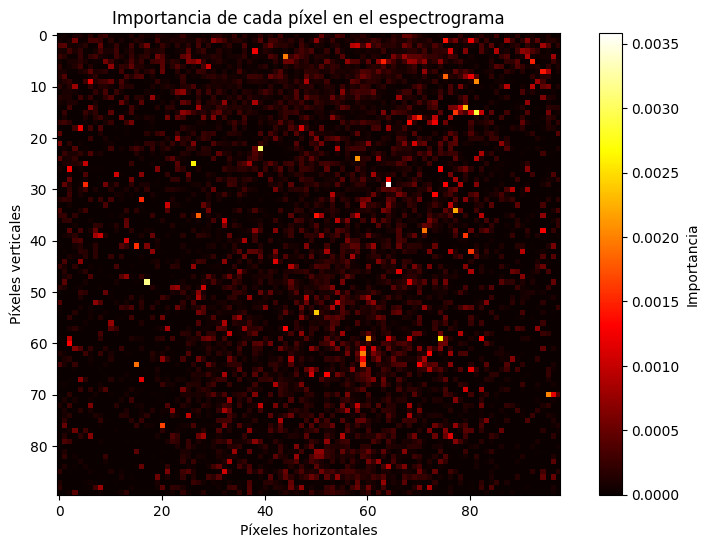

In [ ]:
# Reshape de las importancias para que coincida con la forma del espectrograma
importances_img = importances.reshape((90, 98))

# Crear la imagen de importancias
plt.figure(figsize=(10, 6))
plt.imshow(importances_img, cmap='hot', interpolation='nearest')
plt.colorbar(label='Importancia')
plt.title('Importancia de cada píxel en el espectrograma')
plt.xlabel('Píxeles horizontales')
plt.ylabel('Píxeles verticales')
plt.show()

###4.7.4. Filtrar pixels importantes

In [ ]:
indices_caracteristicas_importantes = np.where(importances > 0.00004646)[0]#0.00004646)[0]#0.000235)[0] # RANDOM FOREST 4000 PIXELS ==> 0.0001011
print(indices_caracteristicas_importantes.shape)
print("Índices de características importantes:", indices_caracteristicas_importantes)

(4000,)
Índices de características importantes: [   1    3    4 ... 8805 8810 8818]


In [ ]:
# Eliminar las columnas con los índices de características importantes
X_filtrado = X[:, indices_caracteristicas_importantes]
print (X.shape)
print(X_filtrado.shape)

(1541, 8820)
(1541, 4000)


##4.8. Guardar X e Y en un txt
Así solo tenemos que cargar los txt si queremos volver a ejecutar en vez de procesar otra vez todas las imágenes.

In [ ]:
RAV_X = "90x98/RAVDESS_x_TFM1_conNeutral2x.txt" #"FINAL1_RAVDESS_x_TFM_neutral2x.txt"
RAV_Y = "90x98/RAVDESS_y_TFM1_conNeutral2x.txt"

In [ ]:
X_numeric = X.astype(float) # savetxt peta si no porque X  contiene cadenas de texto (<U1) en vez de '%.18e'
np.savetxt(RUTA + RAV_X, X_numeric)
y_numeric = y.astype(int)
np.savetxt(RUTA + RAV_Y, y_numeric)

##4.9. Cargar X e Y ya procesado
Para ahorrar tiempo

In [ ]:
X = np.loadtxt(RUTA + RAV_X)
y = np.loadtxt(RUTA + RAV_Y)
print(X.shape)
print(y.shape)

(1541, 8820)
(1541,)


# 5. Red Neuronal
## 5.1. Preparar los conjuntos de datos para la red neuronal
- Primero normalizamos los datos, y codificamos las clases.
- Luego hacemos un split del conjunto de datos: 80% train, 10% validation, 10% test.


In [ ]:
params = [ #Hidden layer, alfa, epochs
    # LEARNING RATE = 0.0001
    [800, 0.0001, 40],     [800, 0.0001, 50],     [800, 0.0001, 80],     [800, 0.0001, 100],     [800, 0.0001, 150],     [800, 0.0001, 200],
    [1000, 0.0001, 40],    [1000, 0.0001, 50],    [1000, 0.0001, 80],    [1000, 0.0001, 100],    [1000, 0.0001, 150],    [1000, 0.0001, 200],
    [1200, 0.0001, 40],    [1200, 0.0001, 50],    [1200, 0.0001, 80],    [1200, 0.0001, 100],    [1200, 0.0001, 150],    [1200, 0.0001, 200],
    [1500, 0.0001, 40],    [1500, 0.0001, 50],    [1500, 0.0001, 80],    [1500, 0.0001, 100],    [1500, 0.0001, 150],    [1500, 0.0001, 200],
    [1600, 0.0001, 40],    [1600, 0.0001, 50],    [1600, 0.0001, 80],    [1600, 0.0001, 100],    [1600, 0.0001, 150],    [1600, 0.0001, 200],
    [2000, 0.0001, 40],    [2000, 0.0001, 50],    [2000, 0.0001, 80],    [2000, 0.0001, 100],    [2000, 0.0001, 150],    [2000, 0.0001, 200],

    # LEARNING RATE = 0.001
    # [800, 0.001, 40],    [800, 0.001, 50],     [800, 0.001, 80],    [800, 0.001, 100],     [800, 0.001, 150],    [800, 0.001, 200],
    #  [1000, 0.001, 40],    [1000, 0.001, 50],    [1000, 0.001, 80],    [1000, 0.001, 100],    [1000, 0.001, 150],    [1000, 0.001, 200],
    #  [1200, 0.001, 40],    [1200, 0.001, 50],    [1200, 0.001, 80],    [1200, 0.001, 100],    [1200, 0.001, 150],    [1200, 0.001, 200],
    # [1500, 0.001, 40],    [1500, 0.001, 50],    [1500, 0.001, 80],    [1500, 0.001, 100],    [1500, 0.001, 150],    [1500, 0.001, 200],
    # [1600, 0.001, 40],    [1600, 0.001, 50],    [1600, 0.001, 80],    [1600, 0.001, 100],    [1600, 0.001, 150],    [1600, 0.001, 200],
    # [2000, 0.001, 40],    [2000, 0.001, 50],    [2000, 0.001, 80],    [2000, 0.001, 100],    [2000, 0.001, 150],    [2000, 0.001, 200],
]

In [ ]:
# Normalización de datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtrado)
#X_scaled = scaler.fit_transform(X)

# Codificación de etiquetas
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
onehot_encoder = OneHotEncoder(sparse=False)
y_encoded = y_encoded.reshape(-1, 1)
y_onehot = onehot_encoder.fit_transform(y_encoded)

#print(X_filtrado.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
def confusion_mat(Xs_test, ys_test, ys_pred):
    # Convertir listas de nuevo a arrays numpy
    X_test = np.array(Xs_test)
    y_test = np.array(ys_test)
    y_pred = np.array(ys_pred)

    # Predicciones en el conjunto de prueba
    y_pred_classes = np.argmax(ys_pred, axis=1)
    y_true_classes = np.argmax(ys_test, axis=1)

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
    print("Confusion Matrix (in counts):")
    print(conf_matrix)

    # Convertir a porcentaje
    conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
    print("Confusion Matrix (in percentages):")
    print(conf_matrix_percentage)

    # Nombres de clases
    class_names = ['Neutral', 'Calma', 'Felicidad', 'Tristeza', 'Enojo', 'Miedo', 'Disgusto', 'Sorpresa']

    # Reporte de clasificación
    class_report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
    print("Classification Report:")
    print(class_report)

    # Visualización de la matriz de confusión en porcentajes
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.title('Matriz de confusión (en %)')
    plt.show()

Epoch 1/200
10/10 [==============================] - 2s 186ms/step - loss: 2.4800 - accuracy: 0.2167 - val_loss: 1.8268 - val_accuracy: 0.3571
Epoch 2/200
10/10 [==============================] - 1s 125ms/step - loss: 1.4850 - accuracy: 0.4781 - val_loss: 1.5657 - val_accuracy: 0.4221
Epoch 3/200
10/10 [==============================] - 1s 146ms/step - loss: 1.0759 - accuracy: 0.6209 - val_loss: 1.4751 - val_accuracy: 0.4935
Epoch 4/200
10/10 [==============================] - 2s 156ms/step - loss: 0.8391 - accuracy: 0.7037 - val_loss: 1.4206 - val_accuracy: 0.5065
Epoch 5/200
10/10 [==============================] - 2s 216ms/step - loss: 0.6466 - accuracy: 0.7679 - val_loss: 1.2924 - val_accuracy: 0.5390
Epoch 6/200
10/10 [==============================] - 2s 191ms/step - loss: 0.5273 - accuracy: 0.8231 - val_loss: 1.2660 - val_accuracy: 0.5649
Epoch 7/200
10/10 [==============================] - 2s 235ms/step - loss: 0.4267 - accuracy: 0.8782 - val_loss: 1.1966 - val_accuracy: 0.6104

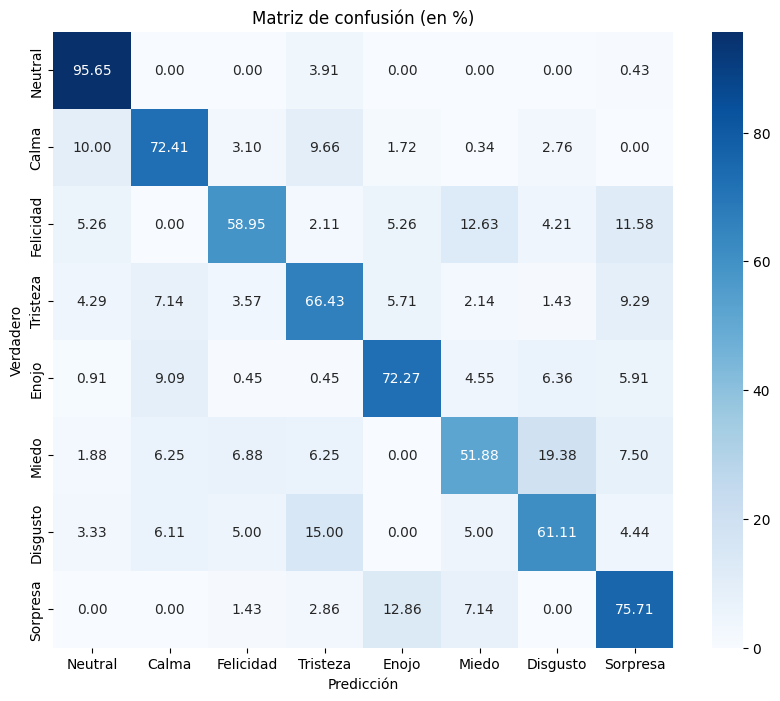

In [ ]:
dic_results = {}
INTENTOS = 10

for nn in params:
  #Hiperparametros:
  #input_layer = X.shape[1]
  input_layer = X_filtrado.shape[1]
  dropout = 0.5
  batch_size_ = 128
  hidden_layer = nn[0]
  learning_rate_ = nn[1]
  epochs_ = nn[2]
  #Optimizador ADAM:
  beta1 = 0.9
  beta2 = 0.999
  #Optimizador Stochastic Gradient Descent (SGD)
  momentum_ = 0.8

  total_loss = 0
  total_accuracy = 0
  ys_pred =[]
  ys_test=[]
  Xs_test=[]

  for i in range (0, INTENTOS): # 3 intentos
    # División en conjuntos de entrenamiento, validación y prueba
    X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_onehot, test_size=0.2, random_state=42) # 80%
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) # 10, 10%

    # Configurar modelo
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hidden_layer, input_dim=input_layer, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(8, activation='softmax') #Dado que no hay neutral, son 7 clases en vez de 8
    ])

    # Optimizador ADAM:
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_, beta_1=beta1, beta_2=beta2)
    # Optimizador SGD
    #optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate_, momentum=momentum_)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    #Entrenar NN:
    history = model.fit(X_train, y_train, epochs=epochs_, batch_size=batch_size_, validation_data=(X_val, y_val)) # validation_split=0.1)

    # Precisión:
    loss, accuracy = model.evaluate(X_test, y_test)
    total_loss += loss
    total_accuracy += accuracy

    # Matriz de confusion
    y_pred_aux = model.predict(X_test)

    ys_pred.extend(y_pred_aux)
    ys_test.extend(y_test)
    Xs_test.extend(X_test)


  # Fin For Intentos
  clave = f"{hidden_layer} NEURONS + {learning_rate_} ALPHA + {epochs_} EPOCHS"

  total_loss /= INTENTOS
  total_accuracy /= INTENTOS
  dic_results[clave] = (total_loss, total_accuracy)

  print(clave)
  print(f' ==> Loss: {total_loss}, Accuracy: {total_accuracy}')

  confusion_mat(Xs_test, ys_test, ys_pred)


In [ ]:
print (dic_results)

{'1000 NEURONS + 0.0001 ALPHA + 100 EPOCHS': (0.993205064535141, 0.6916129052639007), '1000 NEURONS + 0.0001 ALPHA + 150 EPOCHS': (1.0237606346607209, 0.68709676861763), '1000 NEURONS + 0.0001 ALPHA + 200 EPOCHS': (1.023726224899292, 0.6954838633537292), '1200 NEURONS + 0.0001 ALPHA + 40 EPOCHS': (0.9740155875682831, 0.6780645251274109), '1200 NEURONS + 0.0001 ALPHA + 50 EPOCHS': (0.9837702810764313, 0.6800000011920929), '1200 NEURONS + 0.0001 ALPHA + 80 EPOCHS': (0.9748253107070923, 0.6819354832172394), '1200 NEURONS + 0.0001 ALPHA + 100 EPOCHS': (1.0081000089645387, 0.6787096798419953), '1200 NEURONS + 0.0001 ALPHA + 150 EPOCHS': (0.9987221181392669, 0.698064512014389), '1200 NEURONS + 0.0001 ALPHA + 200 EPOCHS': (1.0430885553359985, 0.6935483813285828)}
